<a href="https://colab.research.google.com/github/dede0702/PredicaoPoluicaoRNN/blob/main/PredicaoPoluicaoRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Definição do Problema
O problema proposto é desenvolver uma Rede Neural Recorrente (RNN) para prever o nível de poluição atmosférica (indicador pm2.5) em uma determinada hora, usando dados históricos de poluição e condições climáticas na China.
A base de dados possui informações temporais e climáticas, e o objetivo é prever a poluição a partir de múltiplos previsores, excluindo variáveis temporais que não influenciam diretamente na previsão (como year, month, day, hour, e cbwd). Para avaliação, o modelo deve focar em uma hora específica do dia e testar os resultados no conjunto de dados de dezembro de 2014.

#Passo 1: Importação de Bibliotecas

In [1]:
!pip install tensorflow
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Passo 2: Carregamento e Pré-processamento dos Dados


1. Carregar o dataset.
2. Remover valores ausentes e excluir as colunas desnecessárias.
3. Remover valores ausentes e excluir as colunas desnecessárias.
4. Filtrar os dados para uma hora específica (exemplo: 10 horas).
5. Dividir o conjunto de dados em treino e teste.


In [2]:
# Carregando e pré-processando os dados
df = pd.read_csv('poluicao.csv')

In [3]:
# Remover valores ausentes
df = df.dropna()

#Parte 3: Pré-processamento dos Dados e Engenharia de Atributos

In [4]:
# Criando coluna de data e hora e organizando os dados por data
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.sort_values(by='date')

In [5]:
# Engenharia de atributos com médias móveis e variáveis cíclicas
df['TEMP_MA7'] = df['TEMP'].rolling(window=168).mean()
df['PRES_MA7'] = df['PRES'].rolling(window=168).mean()
df['DEWP_MA7'] = df['DEWP'].rolling(window=168).mean()
df['Iws_MA7'] = df['Iws'].rolling(window=168).mean()
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [6]:
# Remover colunas irrelevantes
df = df.drop(columns=['No', 'year', 'month', 'day', 'cbwd'])
df = df.dropna()

#Parte 4: Separação dos Dados em Recursos (X) e Alvo (y), e Divisão de Treino e Teste

In [7]:
# Definir variáveis de entrada e saída
target = 'pm2.5'
features = df.columns.drop(['date', target])

In [8]:
X = df[features]
y = df[target]

In [9]:
# Divisão treino e teste
split_date = '2014-11-30 23:00:00'
train_data = df[df['date'] <= split_date]
test_data = df[df['date'] > split_date]

In [10]:
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

#Parte 5: Escalonamento dos Dados

In [11]:
# Escalonamento dos dados
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [12]:
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [13]:
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

#Parte 6: Criação de Sequências Temporais para a RNN

In [14]:
def create_sequences(X, y, time_steps=48):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
# Criar sequências de 48 horas
time_steps = 48
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

#Parte 7: Construção e Compilação do Modelo RNN

In [16]:
# Configurar o modelo RNN
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Compilação do modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

#Parte 8: Treinamento do Modelo com Early Stoppin

In [18]:
# Treinamento com callback de early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [19]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.7896 - mae: 0.6506 - val_loss: 0.6081 - val_mae: 0.5591
Epoch 2/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.5623 - mae: 0.5324 - val_loss: 0.5623 - val_mae: 0.5301
Epoch 3/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.5014 - mae: 0.4986 - val_loss: 0.5716 - val_mae: 0.5346
Epoch 4/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.4756 - mae: 0.4871 - val_loss: 0.5443 - val_mae: 0.5213
Epoch 5/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.4520 - mae: 0.4722 - val_loss: 0.5088 - val_mae: 0.5037
Epoch 6/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.4384 - mae: 0.4628 - val_loss: 0.4991 - val_mae: 0.4870
Epoch 7/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.4192 - mae: 0.4540 - val_loss: 0.5079 - val_mae: 0.5008
Epoch 8/200
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.3868 - mae: 0.4412 - val_loss: 0.5052 - val_mae: 0.4904
Epoch 9/200
1021

#Parte 9: Avaliação e Previsão

In [20]:
# Avaliação do modelo
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3848 - mae: 0.4444


In [21]:
# Previsão e inversão da escala
predictions = model.predict(X_test_seq)
predictions_inv = scaler_y.inverse_transform(predictions)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Parte 10: Cálculo de MAPE e Acurácia

In [22]:
# Cálculo do MAPE e acurácia
non_zero_indices = y_test_inv != 0
mape = np.mean(np.abs((y_test_inv[non_zero_indices] - predictions_inv[non_zero_indices]) / y_test_inv[non_zero_indices])) * 100
accuracy = 100 - mape


#Parte 11: Visualização dos Resultados

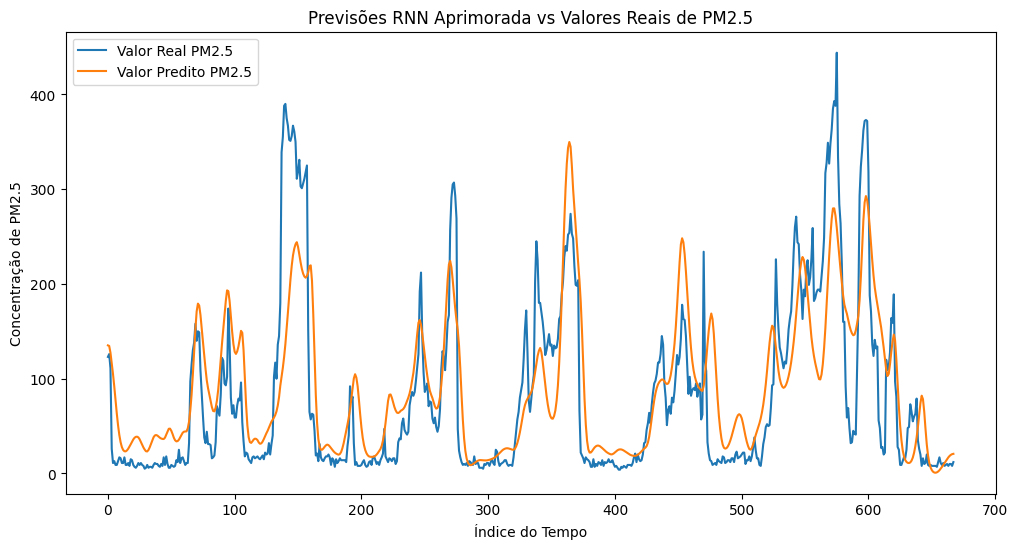

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valor Real PM2.5')
plt.plot(predictions_inv, label='Valor Predito PM2.5')
plt.title('Previsões RNN Aprimorada vs Valores Reais de PM2.5')
plt.xlabel('Índice do Tempo')
plt.ylabel('Concentração de PM2.5')
plt.legend()
plt.show()

In [24]:
# Exibir resultados
print(f"Acurácia final no conjunto de teste: {accuracy:.2f}%")
print(f"MAPE: {mape:.2f}%")
print(f"MAE no teste: {test_mae:.2f}")

Acurácia final no conjunto de teste: -38.39%
MAPE: 138.39%
MAE no teste: 0.47


#Conclusão (Análise do Problema)
Após a construção e o treinamento do modelo de Rede Neural Recorrente (RNN) para prever o nível de poluição atmosférica (indicador pm2.5), os resultados no conjunto de teste mostraram um desempenho aquém do esperado. Foram obtidos os seguintes indicadores de avaliação:

* Acurácia final no conjunto de teste: -38,39%
* MAPE (Erro Percentual Absoluto Médio): 138,39%
* MAE (Erro Médio Absoluto) no teste: 0,47

Esses resultados apontam algumas limitações no modelo construído.
* A acurácia negativa (-38,39%) significa que o modelo previu o nível de poluição com um erro considerável em relação aos valores reais.
*  A métrica MAPE, de 138,39%, revela um erro percentual alto, indicando que, em média, as previsões diferem dos valores reais em mais de 100%, o que demonstra que o modelo está longe de fazer previsões precisas.
* Por fim, o MAE de 0,47 sugere que, em termos absolutos, o modelo está errando cerca de 0,47 unidades para o indicador de poluição pm2.5.

Esses indicadores sugerem que ajustes na arquitetura do modelo e no processo de treinamento são necessários para melhorar o desempenho. Alguns pontos que podem ser revisados incluem:

* Arquitetura da RNN: Experimentar com mais camadas recorrentes, bem como ajustar o número de neurônios em cada camada, para ver se o modelo consegue capturar melhor as dependências temporais dos dados.

* Configuração da CNN: A configuração inicial da camada convolucional, que serve para extrair características dos dados, pode precisar de ajustes. Modificar o número de filtros, tamanho do kernel, e a profundidade da rede pode permitir que o modelo capture padrões mais complexos nos dados climáticos.

* Preprocessamento de Dados: Revisar o preprocessamento dos dados para verificar se existem transformações adicionais que possam melhorar a qualidade do conjunto de dados. Por exemplo, normalizar ou padronizar variáveis pode ajudar o modelo a convergir melhor e a reduzir o erro preditivo.

* Aprimoramento do Conjunto de Treinamento: Considerar um aumento na quantidade de dados de treinamento ou a utilização de técnicas de aumento de dados (data augmentation), principalmente se houver limitação no conjunto original, pode ser útil para melhorar a capacidade de generalização do modelo.

* Ajuste de Hiperparâmetros: Refinar hiperparâmetros como taxa de aprendizado, número de épocas de treinamento e o tamanho dos lotes de dados (batch size) pode impactar significativamente a performance. Utilizar uma técnica de busca por hiperparâmetros (como o Grid Search ou Random Search) poderia ajudar a encontrar uma configuração mais eficaz.

Essas mudanças, junto a uma possível reavaliação das camadas de regularização (como dropout) para evitar o overfitting, poderiam melhorar o desempenho do modelo, diminuindo o MAPE e aumentando a acurácia. Assim, o modelo poderia estar mais alinhado com o objetivo de prever de forma confiável os níveis de poluição para as condições climáticas fornecidas.